# 泰坦尼克号生存率预测

# 1.提出问题

什么样的人在泰坦尼克号中更容易存活？

# 2.理解数据

## 2.1 采集数据

从Kaggle泰坦尼克号项目页面下载数据：https://www.kaggle.com/c/titanic

## 2.2 导入所需的第三方分析包

In [327]:
# 忽略警告提示
import warnings
warnings.filterwarnings('ignore')

#导入处理数据包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## 2.3 对训练数据进行探索

In [328]:
#训练数据集
train_data = pd.read_csv("./Titanic-data/train.csv")
print ('训练数据集:',train_data.shape)

训练数据集: (891, 12)


In [329]:
#查看数据
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [330]:
# 查看每一列的数据类型，和数据总数
train_data.info()
print('-' * 40)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
----------------------------------------


训练数据集总共有891条数据

其中数值类型的列：年龄（Age）有缺失数据：

1）年龄（Age）里面数据总数是714条，缺失了891-714=177，缺失率177/891=20%


字符串列：

1）登船港口（Embarked）里面数据总数是889，只缺失了2条数据，缺失比较少

2）船舱号（Cabin）里面数据总数是204，缺失了891-204=687，缺失率=687/891=77%，缺失比较大

* 绘制性别与生还的关系图

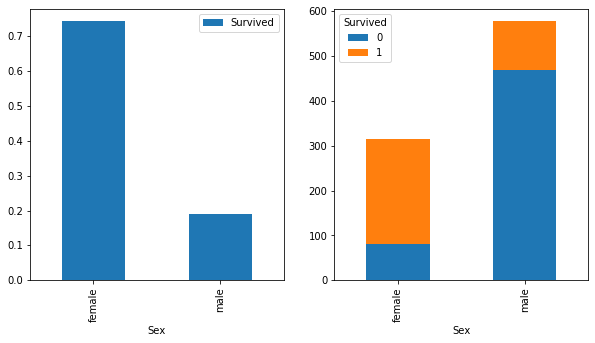

In [331]:
fig,axes = plt.subplots(1,2,figsize=(10,5))
train_data[['Sex','Survived']].groupby(['Sex']).mean().plot.bar(ax=axes[0])
pd.crosstab(train_data.Sex,train_data.Survived).plot.bar(stacked=True,ax=axes[1])

由图可看出，女士生存几率远高于男士，体现了女士优先的精神

* 绘制年龄、性别与生还的关系图

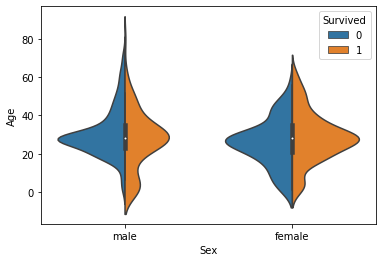

In [332]:
#由于年龄有缺失值，先用年龄的中位数填补
train_data['Age']=train_data['Age'].fillna(train_data['Age'].median())
sns.violinplot(x='Sex', y='Age', hue='Survived', data=train_data, split=True)

我们发现大部门乘客的年龄都在20岁~40岁之间，年纪小女性的更有机会存活

* 登船港口与生还关系

出发地点：S=英国南安普顿Southampton

途径地点1：C=法国 瑟堡市Cherbourg

途径地点2：Q=爱尔兰 昆士敦Queenstown

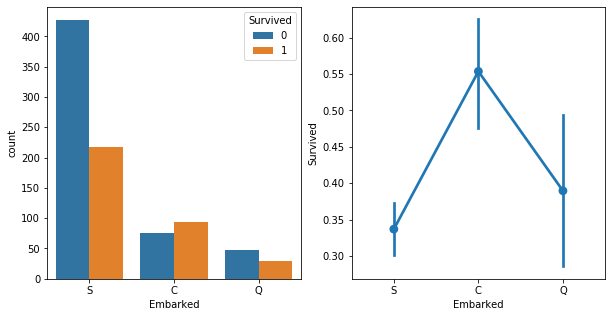

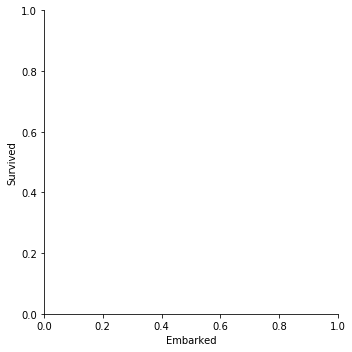

In [333]:
fig,axes = plt.subplots(1,2,figsize=(10,5))
sns.countplot(data=train_data,x='Embarked', hue='Survived',ax=axes[0])
sns.factorplot('Embarked', 'Survived', data=train_data,ax=axes[1])
plt.show()

如上图可看出，登船港口与生还是有一定关系的，在瑟堡市Cherbourg(C)登船口登船的人生还几率较高

* 船舱等级、价格与生还关系分析

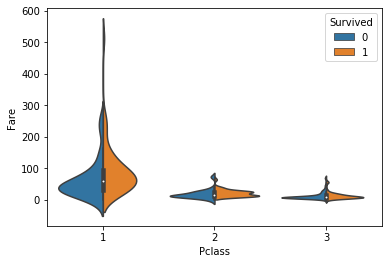

In [334]:
sns.violinplot(x='Pclass', y='Fare', hue='Survived', data=train_data, split=True)

上图可看出，在票价高的高级舱存活概率大很多

# 3、特征工程

## 3.1 数据预处理

###  缺失值处理

很多机器学习算法为了训练模型，要求所传入的特征中不能有空值，在训练模型前需要对数据的缺失值进行处理，处理的方法一般有下列几种方法

1. 如果数据量很大，但缺失值很少，可以删掉带缺失值的行
2. 如果是数值类型，且缺失值不是很多，可以用平均值、中位数，众数来填充
3. 如果是分类数据，用最常见的类别取代
4. 使用模型预测缺失值，例如：K-NN

当然最重要的还是对业务的理解，方法只是有指导意义，具体还是要具体业务具体分析，采取合理的方法进行缺失值处理

In [335]:
#训练集
train_data = pd.read_csv("./Titanic-data/train.csv")
#测试集
test_data = pd.read_csv("./Titanic-data/test.csv")
#合并数据集，方便同时对两个数据集进行清洗
full_data = pd.concat( [train_data,test_data] , ignore_index = True )

print ('合并后的数据集:',full_data.shape)

合并后的数据集: (1309, 12)


* 船舱号(cabin)

In [336]:
'''
船舱号（Cabin）里面数据总数是295，缺失了1309-295=1014，缺失率=1014/1309=77.5%，缺失比较大，用'U'填充代表未知
'''
full_data['Cabin'].fillna('U',inplace=True)
full_data['Cabin'].head()

0       U
1     C85
2       U
3    C123
4       U
Name: Cabin, dtype: object

In [337]:
#只保留取船舱的首字母，只要了解具体的船舱就可以，具体的位置就不管了
full_data['Cabin']=full_data['Cabin'].apply(lambda x:x[0])
#多出的一个舱位T，票价也不贵，把它划到G
full_data['Cabin'].loc[full_data['Cabin']=='T']='G'

* 登船港口

In [338]:
'''登船港口有两个缺失值，所以我直接填充为出现数量最多的港口'''
full_data['Embarked']=full_data['Embarked'].fillna(full_data['Embarked'].mode().values[0])

* 票价（Fare）

In [339]:
#票价有一个缺失值，用票价的中位数填充
full_data['Fare']=full_data['Fare'].fillna(full_data['Fare'].median())

* 名字(name)

In [340]:
#名字里有Mr、Miss、Mrs字样，将其提取出来
full_data['Title']=full_data['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

In [341]:
'''
定义以下几种头衔类别：
Officer政府官员
Royalty王室（皇室）
Mr已婚男士
Mrs已婚妇女
Miss年轻未婚女子
Master有技能的人/教师
'''
#姓名中头衔字符串与定义头衔类别的映射关系
title_mapDict = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"
                    }

full_data['Title'] = full_data['Title'].map(title_mapDict)
full_data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,U,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr
1,38.0,C,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs
2,26.0,U,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss
3,35.0,C,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs
4,35.0,U,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr


* 年龄(age)

In [342]:
#填充年龄，采用不同称呼的乘客年龄的中位数来填充
age_median=full_data.groupby('Title')['Age'].median()
def fillage (cols):
    age=cols[0]
    title=cols[1]
    if pd.isnull(age):
        return age_median[title]
    return age
full_data['Age']=full_data[['Age','Title']].apply(fillage,axis=1)
full_data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,U,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr
1,38.0,C,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs
2,26.0,U,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss
3,35.0,C,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs
4,35.0,U,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr


## 3.2 特征提取

### 3.2.1数据分类

查看数据类型，分为3种数据类型。并对类别数据处理：用数值代替类别，并进行One-hot编码

1.定性(Quantitative)变量可以以某种方式排序，Age就是一个很好的列子。

2.定量(Qualitative)变量描述了物体的某一（不能被数学表示的）方面，Embarked就是一个例子。

In [343]:
'''
1.数值类型：
乘客编号（PassengerId），年龄（Age），船票价格（Fare），同代直系亲属人数（SibSp），不同代直系亲属人数（Parch）
2.时间序列：无
3.分类数据：
1）有直接类别的
乘客性别（Sex）：男性male，女性female
登船港口（Embarked）：出发地点S=英国南安普顿Southampton，途径地点1：C=法国 瑟堡市Cherbourg，出发地点2：Q=爱尔兰 昆士敦Queenstown
客舱等级（Pclass）：1=1等舱，2=2等舱，3=3等舱
2）字符串类型：可能从这里面提取出特征来，也归到分类数据中
乘客姓名（Name）
客舱号（Cabin）
船票编号（Ticket）
'''
full_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
Age            1309 non-null float64
Cabin          1309 non-null object
Embarked       1309 non-null object
Fare           1309 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
Title          1309 non-null object
dtypes: float64(3), int64(4), object(6)
memory usage: 133.1+ KB


### 3.2.1 分类数据：有直接类别的

1. 乘客性别（Sex）：
男性male，女性female
2. 登船港口（Embarked）：出发地点S=英国南安普顿Southampton，途径地点1：C=法国 瑟堡市Cherbourg，出发地点2：Q=爱尔兰 昆士敦Queenstown
3. 客舱等级（Pclass）：1=1等舱，2=2等舱，3=3等舱

####  性别

In [344]:
#查看性别数据这一列
full_data['Sex'].head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: object

In [345]:
'''
将性别的值映射为数值
男（male）对应数值1，女（female）对应数值0
'''
sex_mapDict={'male':1,
            'female':0}
#map函数：对Series每个数据应用自定义的函数计算
full_data['Sex']=full_data['Sex'].map(sex_mapDict)
full_data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,U,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,1,1,0.0,A/5 21171,Mr
1,38.0,C,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,1,1.0,PC 17599,Mrs
2,26.0,U,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,0,0,1.0,STON/O2. 3101282,Miss
3,35.0,C,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,0,1,1.0,113803,Mrs
4,35.0,U,S,8.0500,"Allen, Mr. William Henry",0,5,3,1,0,0.0,373450,Mr


#### 登船港口(Embarked)

In [346]:
#存放提取后的特征
#embarkedDf = pd.DataFrame()

'''
使用get_dummies进行one-hot编码，产生虚拟变量（dummy variables），列名前缀是Embarked
'''
embarkedDf = pd.get_dummies( full_data['Embarked'] , prefix='Embarked' )
embarkedDf.head()

,Embarked_C,Embarked_Q,Embarked_S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


In [347]:
#添加one-hot编码产生的虚拟变量（dummy variables）到泰坦尼克号数据集full
full_data = pd.concat([full_data,embarkedDf],axis=1)

'''
因为已经使用登船港口(Embarked)进行了one-hot编码产生了它的虚拟变量（dummy variables）
所以这里把登船港口(Embarked)删掉
'''
full_data.drop('Embarked',axis=1,inplace=True)

#### 客舱等级（Pclass）

In [348]:
'''
客舱等级(Pclass):
1=1等舱，2=2等舱，3=3等舱
'''
#使用get_dummies进行one-hot编码，列名前缀是Pclass
pclassDf = pd.get_dummies( full_data['Pclass'] , prefix='Pclass' )
pclassDf.head()

,Pclass_1,Pclass_2,Pclass_3
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,0,1


In [349]:
#添加one-hot编码产生的虚拟变量（dummy variables）到泰坦尼克号数据集full_data
full_data = pd.concat([full_data,pclassDf],axis=1)

#删掉客舱等级（Pclass）这一列
full_data.drop('Pclass',axis=1,inplace=True)

### 3.2.1 分类数据：字符串类型

字符串类型：可能从这里面提取出特征来，也归到分类数据中，这里数据有：

1. 头衔（Name）
2. 客舱号（Cabin）
3. 船票编号（Ticket）

### 头衔

In [350]:
#添加one-hot编码产生的虚拟变量（dummy variables）到泰坦尼克号数据集full_data
titleDf = pd.get_dummies( full_data['Title'] , prefix='Pclass' )
full_data = pd.concat([full_data,titleDf],axis=1)

#删掉姓名这一列
full_data.drop(['Name','Title'],axis=1,inplace=True)

### 从客舱号中提取客舱类别

In [351]:
'''
客场号的类别值是首字母，例如：
C85 类别映射为首字母C
'''

##使用get_dummies进行one-hot编码，列名前缀是Cabin
cabinDf = pd.get_dummies( full_data['Cabin'] , prefix = 'Cabin' )

cabinDf.head()

,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_U
0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,1


In [352]:
#添加one-hot编码产生的虚拟变量（dummy variables）到泰坦尼克号数据集full_data
full_data = pd.concat([full_data,cabinDf],axis=1)

#删掉客舱号这一列
full_data.drop('Cabin',axis=1,inplace=True)
full_data.head()

,Age,Fare,Parch,PassengerId,Sex,SibSp,Survived,Ticket,Embarked_C,Embarked_Q,...,Pclass_Officer,Pclass_Royalty,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_U
0,22.0,7.2500,0,1,1,1,0.0,A/5 21171,0,0,...,0,0,0,0,0,0,0,0,0,1
1,38.0,71.2833,0,2,0,1,1.0,PC 17599,1,0,...,0,0,0,0,1,0,0,0,0,0
2,26.0,7.9250,0,3,0,0,1.0,STON/O2. 3101282,0,0,...,0,0,0,0,0,0,0,0,0,1
3,35.0,53.1000,0,4,0,1,1.0,113803,0,0,...,0,0,0,0,1,0,0,0,0,0
4,35.0,8.0500,0,5,1,0,0.0,373450,0,0,...,0,0,0,0,0,0,0,0,0,1


### 建立家庭人数和家庭类别

In [353]:
familyDf=pd.DataFrame()
'''
家庭人数=同代直系亲属数（Parch）+不同代直系亲属数（SibSp）+乘客自己
（因为乘客自己也是家庭成员的一个，所以这里加1）
'''
familyDf[ 'FamilySize' ] = full_data[ 'Parch' ] + full_data[ 'SibSp' ] + 1

'''
家庭类别：
小家庭Family_Single：家庭人数=1
中等家庭Family_Small: 2<=家庭人数<=4
大家庭Family_Large: 家庭人数>=5
'''
#if 条件为真的时候返回if前面内容，否则返回0
familyDf[ 'Family_Single' ] = familyDf[ 'FamilySize' ].map( lambda s : 1 if s == 1 else 0 )
familyDf[ 'Family_Small' ]  = familyDf[ 'FamilySize' ].map( lambda s : 1 if 2 <= s <= 4 else 0 )
familyDf[ 'Family_Large' ]  = familyDf[ 'FamilySize' ].map( lambda s : 1 if 5 <= s else 0 )

familyDf.head()

,FamilySize,Family_Single,Family_Small,Family_Large
0,2,0,1,0
1,2,0,1,0
2,1,1,0,0
3,2,0,1,0
4,1,1,0,0


In [354]:
#添加one-hot编码产生的虚拟变量（dummy variables）到泰坦尼克号数据集full_data
full_data = pd.concat([full_data,familyDf],axis=1)
full_data.head()

,Age,Fare,Parch,PassengerId,Sex,SibSp,Survived,Ticket,Embarked_C,Embarked_Q,...,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_U,FamilySize,Family_Single,Family_Small,Family_Large
0,22.0,7.2500,0,1,1,1,0.0,A/5 21171,0,0,...,0,0,0,0,0,1,2,0,1,0
1,38.0,71.2833,0,2,0,1,1.0,PC 17599,1,0,...,1,0,0,0,0,0,2,0,1,0
2,26.0,7.9250,0,3,0,0,1.0,STON/O2. 3101282,0,0,...,0,0,0,0,0,1,1,1,0,0
3,35.0,53.1000,0,4,0,1,1.0,113803,0,0,...,1,0,0,0,0,0,2,0,1,0
4,35.0,8.0500,0,5,1,0,0.0,373450,0,0,...,0,0,0,0,0,1,1,1,0,0


In [355]:
#到现在我们已经有了这么多个特征了
full_data.shape

(1309, 32)

## 3.3 特征选择

相关系数法：计算各个特征的相关系数

In [370]:
#相关性矩阵
corrDf = full_data.corr() 
corrDf.head()

,Age,Fare,Parch,PassengerId,Sex,SibSp,Survived,Embarked_C,Embarked_Q,Embarked_S,...,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_U,FamilySize,Family_Single,Family_Small,Family_Large
Age,1.000000,0.179594,-0.130326,0.025161,0.060982,-0.214720,-0.072174,0.080710,-0.059136,-0.033604,...,0.175148,0.137439,0.109333,-0.071171,-0.061526,-0.284174,-0.212466,0.114964,-0.030395,-0.172922
Fare,0.179594,1.000000,0.221635,0.031128,-0.185681,0.160349,0.257307,0.286368,-0.129958,-0.170068,...,0.401427,0.072786,0.073995,-0.037529,-0.020371,-0.507321,0.226609,-0.275037,0.197468,0.170916
Parch,-0.130326,0.221635,1.000000,0.008942,-0.213125,0.373587,0.081629,-0.008635,-0.100943,0.071881,...,0.009601,-0.027385,0.001084,0.020481,0.048231,-0.036806,0.792296,-0.549022,0.248532,0.624627
PassengerId,0.025161,0.031128,0.008942,1.000000,0.013406,-0.055224,-0.005007,0.048101,0.011585,-0.049836,...,0.006092,0.000549,-0.008136,0.000306,-0.051389,0.000208,-0.031437,0.028546,0.002975,-0.063415
Sex,0.060982,-0.185681,-0.213125,0.013406,1.000000,-0.109609,-0.543351,-0.066564,-0.088651,0.115193,...,-0.077473,-0.057396,-0.040340,-0.006655,-0.067649,0.137396,-0.188583,0.284537,-0.255196,-0.077748


In [357]:
'''
查看各个特征与生成情况（Survived）的相关系数，
ascending=False表示按降序排列
'''
corrDf['Survived'].sort_values(ascending =False)

Survived          1.000000
Pclass_Mrs        0.344935
Pclass_Miss       0.332795
Pclass_1          0.285904
Family_Small      0.279855
Fare              0.257307
Cabin_B           0.175095
Embarked_C        0.168240
Cabin_D           0.150716
Cabin_E           0.145321
Cabin_C           0.114652
Pclass_2          0.093349
Pclass_Master     0.085221
Parch             0.081629
Cabin_F           0.057935
Pclass_Royalty    0.033391
Cabin_A           0.022287
FamilySize        0.016639
Embarked_Q        0.003650
Cabin_G           0.002496
PassengerId      -0.005007
Pclass_Officer   -0.031316
SibSp            -0.035322
Age              -0.072174
Family_Large     -0.125147
Embarked_S       -0.149683
Family_Single    -0.203367
Cabin_U          -0.316912
Pclass_3         -0.322308
Sex              -0.543351
Pclass_Mr        -0.549199
Name: Survived, dtype: float64

根据各个特征与生成情况（Survived）的相关系数大小，我们选择了这几个特征作为模型的输入：

头衔（前面所在的数据集titleDf）、客舱等级（pclassDf）、家庭大小（familyDf）、船票价格（Fare）、船舱号（cabinDf）、登船港口（embarkedDf）、性别（Sex）

In [358]:
#特征选择
full_data_X = pd.concat( [titleDf,#头衔
                     pclassDf,#客舱等级
                     familyDf,#家庭大小
                     full_data['Fare'],#船票价格
                     cabinDf,#船舱号
                     embarkedDf,#登船港口
                     full_data['Sex']#性别
                    ] , axis=1 )
full_data_X.head()

,Pclass_Master,Pclass_Miss,Pclass_Mr,Pclass_Mrs,Pclass_Officer,Pclass_Royalty,Pclass_1,Pclass_2,Pclass_3,FamilySize,...,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_U,Embarked_C,Embarked_Q,Embarked_S,Sex
0,0,0,1,0,0,0,0,0,1,2,...,0,0,0,0,0,1,0,0,1,1
1,0,0,0,1,0,0,1,0,0,2,...,1,0,0,0,0,0,1,0,0,0
2,0,1,0,0,0,0,0,0,1,1,...,0,0,0,0,0,1,0,0,1,0
3,0,0,0,1,0,0,1,0,0,2,...,1,0,0,0,0,0,0,0,1,0
4,0,0,1,0,0,0,0,0,1,1,...,0,0,0,0,0,1,0,0,1,1


# 4.构建模型

用训练数据和某个机器学习算法得到机器学习模型，用测试数据评估模型

## 4.1 建立训练数据集和测试数据集

In [359]:
#原始数据集有891行
sourceRow=len(train_data)

'''
sourceRow是我们在最开始合并数据前知道的，原始数据集有总共有891条数据
从特征集合full_X中提取原始数据集提取前891行数据时，我们要减去1，因为行号是从0开始的。
'''
#原始数据集：特征
source_X = full_data_X.loc[0:sourceRow-1,:]
#原始数据集：标签
source_y = full_data.loc[0:sourceRow-1,'Survived']   

#预测数据集：特征
pred_X = full_data_X.loc[sourceRow:,:]

In [360]:
'''
确保这里原始数据集取的是前891行的数据，不然后面模型会有错误
'''
#原始数据集有多少行
print('预测原始数据集有多少行:',source_X.shape[0])
#预测数据集大小
print('预测原始数据集有多少行:',pred_X.shape[0])

预测原始数据集有多少行: 891
预测原始数据集有多少行: 418


In [361]:
'''
从原始数据集（source）中拆分出训练数据集（用于模型训练train），测试数据集（用于模型评估test）
train_test_split是交叉验证中常用的函数，功能是从样本中随机的按比例选取train data和test data
train_data：所要划分的样本特征集
train_target：所要划分的样本结果
test_size：样本占比，如果是整数的话就是样本的数量
'''
from sklearn.model_selection import train_test_split 

#建立模型用的训练数据集和测试数据集
train_X, test_X, train_y, test_y = train_test_split(source_X ,
                                                    source_y,
                                                    train_size=.8)

#输出数据集大小
print ('原始数据集特征：',source_X.shape, 
       '训练数据集特征：',train_X.shape ,
      '测试数据集特征：',test_X.shape)

print ('原始数据集标签：',source_y.shape, 
       '训练数据集标签：',train_y.shape ,
      '测试数据集标签：',test_y.shape)

原始数据集特征： (891, 26) 训练数据集特征： (712, 26) 测试数据集特征： (179, 26)
原始数据集标签： (891,) 训练数据集标签： (712,) 测试数据集标签： (179,)


In [362]:
#原始数据查看
source_y.head()

0    0.0
1    1.0
2    1.0
3    1.0
4    0.0
Name: Survived, dtype: float64

## 4.2 选择机器学习算法

选择一个机器学习算法，选一个简单的算法（逻辑回归算法），用于模型的训练。

In [363]:
#第1步：导入算法
from sklearn.linear_model import LogisticRegression
#第2步：创建模型：逻辑回归（logisic regression）
model = LogisticRegression()

## 4.3 训练模型

In [364]:
#第3步：训练模型
model.fit( train_X , train_y )

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## 5.评估模型

In [365]:
# 分类问题，score得到的是模型的正确率
model.score(test_X , test_y )

0.8268156424581006

# 6.得到预测结果

使用预测数据集到底预测结果

In [366]:
pred_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 891 to 1308
Data columns (total 26 columns):
Pclass_Master     418 non-null uint8
Pclass_Miss       418 non-null uint8
Pclass_Mr         418 non-null uint8
Pclass_Mrs        418 non-null uint8
Pclass_Officer    418 non-null uint8
Pclass_Royalty    418 non-null uint8
Pclass_1          418 non-null uint8
Pclass_2          418 non-null uint8
Pclass_3          418 non-null uint8
FamilySize        418 non-null int64
Family_Single     418 non-null int64
Family_Small      418 non-null int64
Family_Large      418 non-null int64
Fare              418 non-null float64
Cabin_A           418 non-null uint8
Cabin_B           418 non-null uint8
Cabin_C           418 non-null uint8
Cabin_D           418 non-null uint8
Cabin_E           418 non-null uint8
Cabin_F           418 non-null uint8
Cabin_G           418 non-null uint8
Cabin_U           418 non-null uint8
Embarked_C        418 non-null uint8
Embarked_Q        418 non-null uint8
Em

In [369]:
#使用机器学习模型，对预测数据集中的生存情况进行预测
pred_Y = model.predict(pred_X)

'''
生成的预测值是浮点数（0.0,1,0）
但是Kaggle要求提交的结果是整型（0,1）
所以要对数据类型进行转换
'''
pred_Y=pred_Y.astype(int)
#乘客id
passenger_id = full_data.loc[sourceRow:,'PassengerId']
#数据框：乘客id，预测生存情况的值
predDf = pd.DataFrame( 
    { 'PassengerId': passenger_id , 
     'Survived': pred_Y } )
predDf.shape
predDf.head()
#保存结果
predDf.to_csv( './output/titanic_pred.csv' , index = False )